In [4]:
import numpy as np
from astropy import units as u
from astropy.io import fits
import copy
import poppy
from model_kit import magaoxFunctions as mf
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.axes_grid1

In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # laptop local
data_dir = home_dir + 'data/'
fr_out_dir = 'data_fig/n0_allopd/'

# open all the masks
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

In [14]:
%%time
# Build the PSF without vAPP for non-aberrated Strehl calculation
# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# remove the vAPP
tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1
rx_difflim['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_difflim['surf_PSD_filename'][vappOPD_num] = 'none'

# calculate in POPPY
magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])
dl_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0].data
dl_max = np.amax(dl_psf)

CPU times: user 1min 3s, sys: 16.1 s, total: 1min 19s
Wall time: 33.2 s


In [17]:
# open up the data
dl_psf = poppy.utils.pad_or_crop_to_shape(dl_psf, (fr_parm['npix'], fr_parm['npix']))
sr_open = fits.open(fr_out_dir+'psf_sr_allopd_s2_i0_656nm.fits')[0].data
sr_closed = fits.open(fr_out_dir+'psf_sr_allopd_s2_i4_656nm.fits')[0].data

# calculate the Strehl ratio statistics
# hard copy from analysis_allopd_cal.ipynb
sr_open_avg = 0.691
sr_open_std = 0.047
sr_closed_avg = 0.886
sr_closed_std = 0.006

# calculate the L/D scale factor per pixel
# true scaling for both PSF matrix sizes
psf_hdr = fits.open(fr_out_dir+'psf_sr_allopd_s2_i4_656nm.fits')[0].header
fnum_det = 69
platescl = 206265*u.arcsec / (psf_hdr['DIAM']*u.m * fnum_det)
LD_scale = (1/platescl) * (1/(psf_hdr['PIXELSCL'] * u.m / u.pix)) * (psf_hdr['DIFFLMT'] * u.arcsec)

###################
# Matrix management
###################
# Top row: crop the PSFs one more time for closer viewing
boxsize = int(fr_parm['npix']/2) # Half the size of the window region of interest
srdl_crop = poppy.utils.pad_or_crop_to_shape(dl_psf, (boxsize*2, 2*boxsize))
src_crop = poppy.utils.pad_or_crop_to_shape(sr_closed, (boxsize*2, 2*boxsize))
sro_crop = poppy.utils.pad_or_crop_to_shape(sr_open, (boxsize*2, 2*boxsize))

# rescale the psfs
srpsfc_dl = srdl_crop/np.amax(srdl_crop)
srpsfc_open = sro_crop/np.amax(srdl_crop)
srpsfc_closed = src_crop/np.amax(srdl_crop)
vmin_crop = -7.8

# set the scaling range for the PSF axis
rk = np.linspace(-boxsize, boxsize, (boxsize*2), endpoint=False) * u.pix
rks = (rk / LD_scale).value

# bottom row: zoom in closer
# crop the psfs one more time
zoomsize = 80
srdl_zoom = poppy.utils.pad_or_crop_to_shape(dl_psf, (zoomsize*2, 2*zoomsize))
src_zoom = poppy.utils.pad_or_crop_to_shape(sr_closed, (zoomsize*2, 2*zoomsize))
sro_zoom = poppy.utils.pad_or_crop_to_shape(sr_open, (zoomsize*2, 2*zoomsize))

# rescale the psfs
srzoom_dl = srdl_zoom/np.amax(srdl_zoom)
srzoom_closed = src_zoom/np.amax(srdl_zoom)
srzoom_open = sro_zoom/np.amax(srdl_zoom)
vmin_zoom = -4.8

# set the scaling range for the PSF axis
rk_zoom = np.linspace(-zoomsize, zoomsize, (zoomsize*2), endpoint=False) * u.pix
rks_zoom = (rk_zoom / LD_scale).value

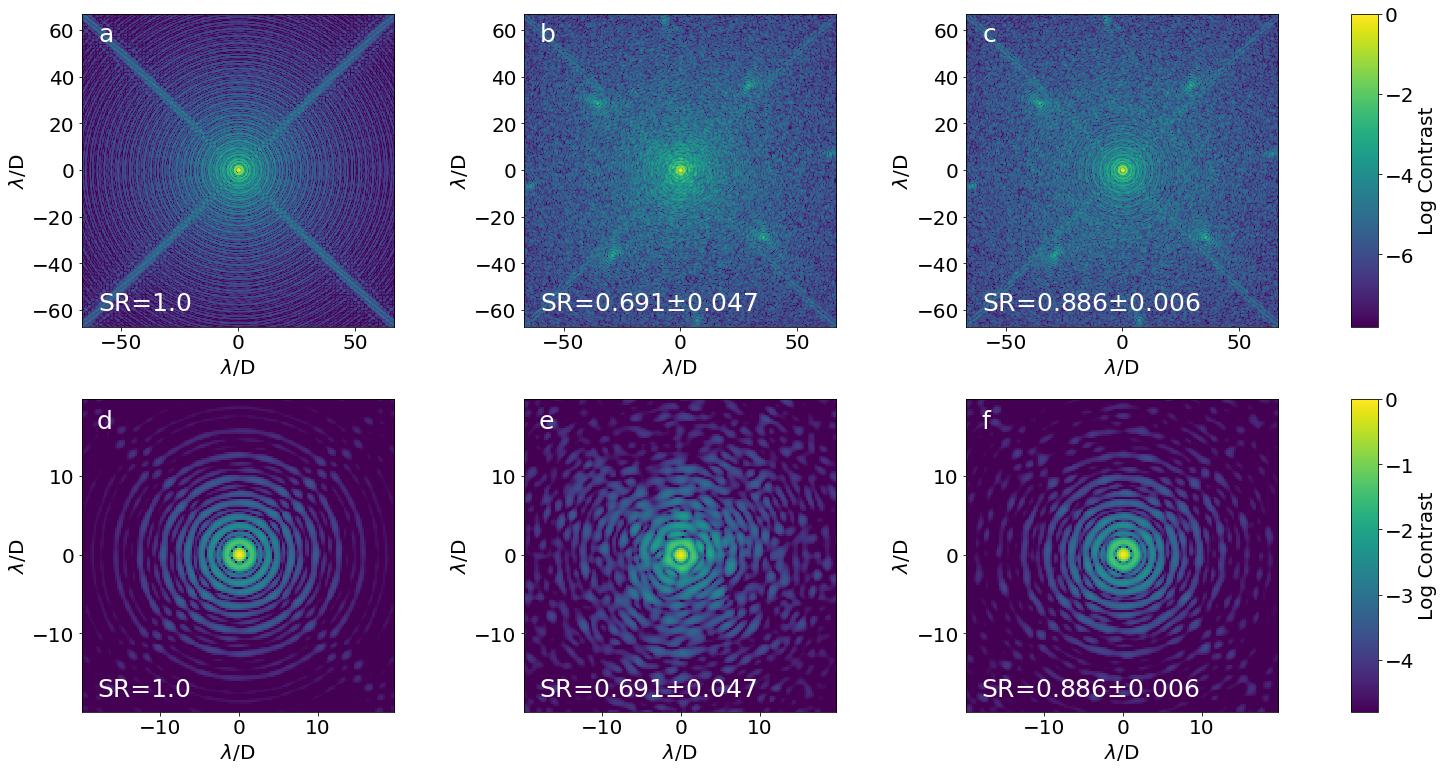

In [27]:
matplotlib.rcParams["font.size"]=20
label_font = 25
fig, axes = plt.subplots(2, 3, figsize=(19, 11))

# top row: big PSF
# 1st PSF: non-aberrated
ima = axes[0,0].imshow(np.log10(srpsfc_dl), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=vmin_crop, vmax=0)
axes[0,0].set_ylabel('$\lambda$/D')
axes[0,0].set_xlabel('$\lambda$/D')
axes[0,0].text(-60, 55, 'a', fontsize=label_font, color='white') #verticalalignment='top', horizontalalignment='left')
axes[0,0].text(-60, -60, 'SR=1.0', fontsize=label_font, color='white')

# second psf: open loop
imb = axes[0,1].imshow(np.log10(srpsfc_open), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=vmin_crop, vmax=0)
axes[0,1].set_ylabel('$\lambda$/D')
axes[0,1].set_xlabel('$\lambda$/D')
axes[0,1].text(-60, 55, 'b', fontsize=label_font, color='white')
axes[0,1].text(-60, -60, 'SR={0:.3f}$\pm${1:.3f}'.format(sr_open_avg,sr_open_std),
               fontsize=label_font, color='white')

# third psf: DM corrected
#ax3 = plt.subplot(133)
imc = axes[0,2].imshow(np.log10(srpsfc_closed), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=vmin_crop, vmax=0)
axes[0,2].set_ylabel('$\lambda$/D')
axes[0,2].set_xlabel('$\lambda$/D')
axes[0,2].text(-60, 55, 'c', fontsize=label_font, color='white')
axes[0,2].text(-60, -60, 'SR={0:.3f}$\pm${1:.3f}'.format(sr_closed_avg,sr_closed_std),
               fontsize=label_font, color='white')

# bottom row: zoomed PSF
# First PSF: non-aberrated
imd = axes[1,0].imshow(np.log10(srzoom_dl), origin='lower',
           extent=[np.amin(rks_zoom), np.amax(rks_zoom), np.amin(rks_zoom), np.amax(rks_zoom)],
           vmin=vmin_zoom, vmax=0)
axes[1,0].set_ylabel('$\lambda$/D')
axes[1,0].set_xlabel('$\lambda$/D')
axes[1,0].text(-18, 16, 'd', fontsize=label_font, color='white') #verticalalignment='top', horizontalalignment='left')
axes[1,0].text(-18, -18, 'SR=1.0', fontsize=label_font, color='white')

# second psf: open loop
#ax2 = plt.subplot(132)
ime = axes[1,1].imshow(np.log10(srzoom_open), origin='lower',
           extent=[np.amin(rks_zoom), np.amax(rks_zoom), np.amin(rks_zoom), np.amax(rks_zoom)],
           vmin=vmin_zoom, vmax=0)
axes[1,1].set_ylabel('$\lambda$/D')
axes[1,1].set_xlabel('$\lambda$/D')
axes[1,1].text(-18, 16, 'e', fontsize=label_font, color='white')
axes[1,1].text(-18, -18, 'SR={0:.3f}$\pm${1:.3f}'.format(sr_open_avg,sr_open_std),
               fontsize=label_font, color='white')

# third psf: DM corrected
#ax3 = plt.subplot(133)
imf = axes[1,2].imshow(np.log10(srzoom_closed), origin='lower',
           extent=[np.amin(rks_zoom), np.amax(rks_zoom), np.amin(rks_zoom), np.amax(rks_zoom)],
           vmin=vmin_zoom, vmax=0)
axes[1,2].set_ylabel('$\lambda$/D')
axes[1,2].set_xlabel('$\lambda$/D')
axes[1,2].text(-18, 16, 'f', fontsize=label_font, color='white')
axes[1,2].text(-18, -18, 'SR={0:.3f}$\pm${1:.3f}'.format(sr_closed_avg,sr_closed_std),
               fontsize=label_font, color='white')

# colorbars
fig.tight_layout()

bbox_ax_top = axes[0,1].get_position()
bbox_ax_bottom = axes[1,1].get_position()

cbar_ima_ax = fig.add_axes([1.01, bbox_ax_top.y0, 0.02, bbox_ax_top.y1-bbox_ax_top.y0])
cbar_ima = plt.colorbar(ima, cax=cbar_ima_ax).set_label('Log Contrast')

cbar_imd_ax = fig.add_axes([1.01, bbox_ax_bottom.y0, 0.02, bbox_ax_bottom.y1-bbox_ax_bottom.y0])
cbar_imd = plt.colorbar(imd, cax=cbar_imd_ax).set_label('Log Contrast')